## Quick review of window function

1. Unlike normal aggregation functions with grouping, which only return one row per group, window functions return all rows, each having their calculated value based on their defined window
2. Window funtion use `[OVER]` [keyword](https:\docs.microsoft.com\en-us\sql\t-sql\queries\select-over-clause-transact-sql?view=sql-server-ver16) and its arguments to define the calculation window
3. There are three main parts of a window function in SQL:

- Grouping: This defines the group that each row belongs to (`PARTITION BY` )
- Order: This sort values within each group and make the window expands incrementally within each group ( `ORDER BY`)
- Range: This is use to further define the window size, within each group ( `ROWS` or `RANGE` )


![aggrigate functions vs windows functions.jpg](attachment:aggrigatefunctionsvswindowsfunctions.jpg)

### OVER (..)

> “Over turns an aggregation function into a window function”

In this first example, we define a simple `SUM` window function `OVER` `duration` column with no arguments. Meaning every row’s window is the same and it is the whole table.

In [0]:
SELECT *
FROM dbo.DailyEfforts;

In [0]:
SELECT
    day,
    duration,
    SUM(duration) OVER() AS total_duration
FROM
    dbo.DailyEfforts;

> So here, each row’s calculation window is exactly the size of their group (based on `start` column)

![T1.gif](attachment:T1.gif)

### OVER (ORDER BY ..)

<span style="color: var(--vscode-foreground);">let us now look at&nbsp;</span> `ORDER BY`  

1. Of course, `ORDER BY` will order rows within their respective group _(we’ll see how ordering works with grouping in the next example)_
2. `ORDER BY` will also force the window to expand gradually (one row at a time) within each group.

In the query, we define no grouping (means the whole table is group for all rows) and the SUM expands in ORDER BY day.

In [0]:
SELECT
    day,
    duration,
    SUM(duration) OVER(ORDER BY day) AS sum_duration_order_by_day
FROM
    dbo.DailyEfforts;

> In simple terms, we get a running sum calculation that just keep adding the current row to the result.

![T2.gif](attachment:T2.gif)


### OVER (PARTITION BY .. ORDER BY ..)

Here comes the interesting part.

> Try and visualize what the below query would do when I:

- calculate windowed `SUM`
- `PARTITION BY` start time
- `ORDER BY` day

In [0]:
SELECT
    day,
    start,
    duration,
    SUM(duration) OVER(PARTITION BY start ORDER BY day) AS sum_duration_sort_by_day
FROM
    dbo.DailyEfforts;

As we can see, the windows resets back to size 1 at the start of each group and incrementally expand its size by one for every next row in the group.

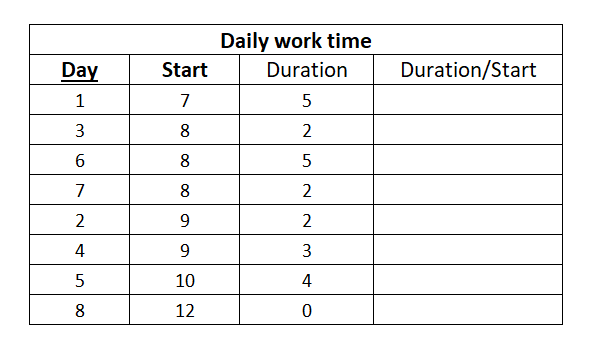

## Some other different window sizes

### Moving aggregation with `ROWS`

In previous section, we’ve seen how window is defined based on grouping. But here (with or without grouping), `ROWS` and `RANGE` allows us to have a more fine grained control over window size.

Say we want to see how many work hours we’ve done for the last two days! This can be done by defining sum over a moving window of size 2.

In [0]:
SELECT
    day,
    duration,
    SUM(duration) OVER(ORDER BY day ROWS BETWEEN 1 PRECEDING AND CURRENT ROW ) AS moving_sum
FROM
    dbo.DailyEfforts;

Result is a moving (or rolling) summation with window size 2.

![T4.gif](attachment:T4.gif)

### Crazy example with all `PARTITION, ORDER, ROWS`

Finally, why dont we put all of these three concept together and see how they ‘interact’?

Our query (a quite meaningless one), defines a windowed summation over (in this exact order):

- First: group by start time
- Second: order by day of work (in each group)
- Third: Window size 2 including current row and one previous row (in the same group)

In [0]:
SELECT
    day,
    start,
    duration,
    SUM(duration) OVER(PARTITION BY start ORDER BY day ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS crazy
FROM
    dbo.DailyEfforts;

Pay very close attention to the tiny difference between this example and the example from section “OVER (PARTITION BY .. SORT BY ..)”

![T5.gif](attachment:T5.gif)

Do notice how the grouping and the ordering still follows rules of `PARTITION BY` and `ORDER BY` like we’ve encounter in previous examples.

Though, how the window is constructed within each group is not incrementally expanding anymore but instead, it follows the defined constraint of `ROWS` , which specify that the window is of size two, including current row and one previous row (if any in the same group)

_This can be seen at_ _day 7 (row 4)_ _where its window is of size 2 despite it being the last row in a group of size 3._

Ref : https://medium.com/learning-sql/sql-window-function-visualized-fff1927f00f2